In [2]:
# Generelle moduler og funksjonsbeskrivelser brukt i forelesningen
from numpy import sin, cos, pi, exp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from Kildekode._11_Frekvensrespons import *

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

def displayFrequencyResponse(b, a=[1], num=None, mag='log', new_figure=True, **kwargs):
    w, Hw = sig.freqz(b, a)
    H_amp = np.abs(Hw)
    H_phase = np.unwrap(np.angle(Hw, deg=True), period=360)
    if new_figure==True:
        if num is not None:
            plt.close(num)
        fig, [ax1, ax2] = plt.subplots(num=num, nrows=2)
    else :
        fig = plt.figure(num=num)
        ax1 = fig.axes[0]
        ax2 = fig.axes[1]
    
    if mag.lower()=='log':
        ax1.plot(w, 20*np.log10(H_amp), **kwargs)
        ax1.set_ylabel(r'$\left| H\left(\hat{\omega}\right)\right|$ (dB)')
    else:
        ax1.plot(w, H_amp, **kwargs)
        ax1.set_ylabel(r'$\left| H\left(\hat{\omega}\right)\right|$')

    ax1.set_xticks(np.linspace(0, 1, 6)*pi, [str(round(i,2))+r'$\pi$' for i in np.linspace(0, 1, 6)])
    ax1.set_xlabel(r'Digital Frekvens $\hat{\omega}$')

    ax1.set_xlim([0, pi])
    ax1.set_title(r'Frekvensrespons $H\left(\hat{\omega}\right)$')

    phaseResp, = ax2.plot(w, H_phase, **kwargs)

    ax2.set_xticks(np.linspace(0, 1, 6)*pi, [str(round(i,2))+r'$\pi$' for i in np.linspace(0, 1, 6)])
    ax2.set_xlabel(r'Digital Frekvens $\hat{\omega}$')
    ax2.set_ylabel(r'$\angle H\left(\hat{\omega}\right)$ (degrees)')

    if "label" in kwargs.keys():
        ax2.legend()
        ax1.legend()
    fig.tight_layout(pad=0.1, w_pad=1.0, h_pad=1.0)

%matplotlib ipympl

<img src="Figurer/NTNU_Logo.png" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# DTFT og praktisk filterdesign

* **Emne AIS2201 - Signalbehandling**
* **Uke 44, 2024**
* **Relevant Pensum:**
    * Kapittel 5.3 - 5.6 i læreboka Understanding Digital Signal Processing
* **Underviser: Kai Erik Hoff**

# Tema

* Repetisjon frekvensrespons
* Idéelle filtre
* Vindusmetoden for tilnærming til ideelle lavpassfiltre
* Nøkkelbegrep i filterdesign
* Andre designmetoder i Python

# Frekvensrespons Oppsummert
* Frekvensresponsen til et digitalt filter identifiseres ved å finne *frekvensinnholdet* $H(\hat{\omega})$ til filterets impulsrespons $h[n]$.
    * Kan utføres analytisk med *Diskret-Tids FourierTransformasjon*
    $$H\left(\hat{\omega} \right) = \text{DTFT}(h[n]) = \sum_{n=0}^{\infty} h[n]\cdot e^{-j\hat{\omega}\cdot n}$$
    * Kan utføres numerisk i `python` med funksjonen `scipy.signal.freqz()`:
```python
w, Hw = scipy.signal.freqz(hn)
```
* Frekvensesponsen $H(\hat{\omega})$ Deles opp i **Styrkegradsrespons** $|H(\hat{\omega})|$ og **Faserespons** $\angle H(\hat{\omega})$
    * **Styrkegradsrespons** forteller hvor mye en sinussekvens forsterkes/dempes, gitt digital frekvens $\hat{\omega}$.
    * **Faserespons** forteller hvor mange radianer sinussekvensen ut av filteret er forskjøvet i forhold til inngangssignalet, gitt digital frekvens $\hat{\omega}$.

* Frekvensresponsen beskriver forholdet mellom inngangssignal og utgangssignal til et filter i frekvensplanet.
$$Y\left(\hat{\omega} \right) = X\left(\hat{\omega} \right)\cdot H\left(\hat{\omega} \right) \leftrightarrow H\left(\hat{\omega} \right) = \frac{Y\left(\hat{\omega} \right)}{X\left(\hat{\omega} \right)}$$
* Forteller hvordan filteret vil påvirke et hvilket som helst sinusformet signal:
\begin{align}
x[n] &=  A\cdot \cos(\hat{\omega}_0 \cdot n + \phi)\\
& \downarrow \\
y[n] &= \left| H\left(\hat{\omega}_0 \right)\right| \cdot A\cdot \cos\left(\hat{\omega}_0 \cdot n + \phi + \angle H\left(\hat{\omega}_0 \right)\right)
\end{align}

## Demo: Frekvensrespons "bånbegrenset derivasjonsfilter"

Output()

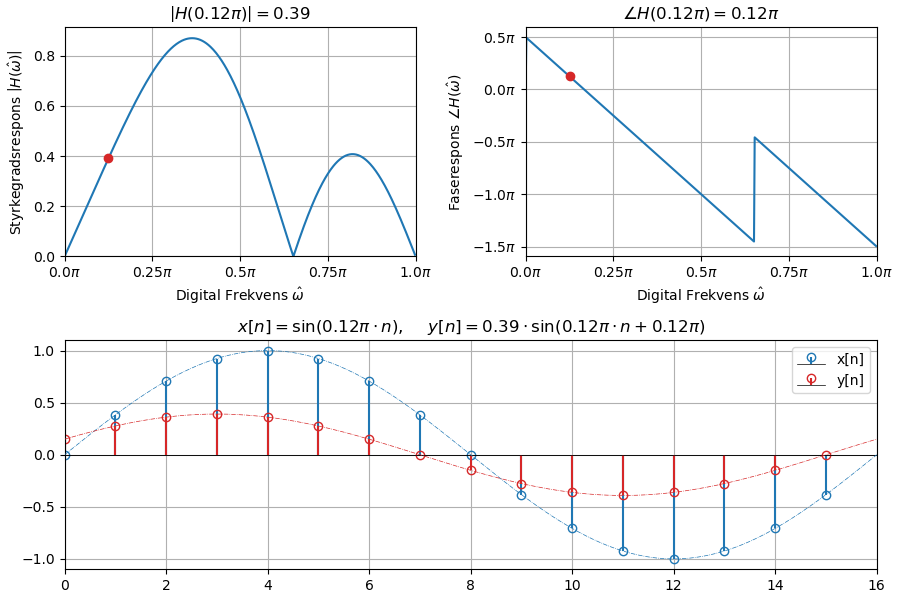

In [3]:
hn = np.array([-22, 67, 58, 0, -58, -67, 22])/252 # Alternativt differansefilter med demping av høyfrekvent innhold
FreqRespDemo(hn, figsize=(9,6));

# Frekvensanalyse vs. Filterdesign
<div style="width: 100%;">
    <div style="width: 45%; float: left">
    <br>
    <h3> Frekvensanalyse </h3>
    <ol>
        <li>Signalsampler i tid er kjent.</li>
        <li>Frekvensinnhold er foreløpig <i>ikke</i> kjent </li>
        <li>Vi ønsker å identifisere signalets frekvenskomponenter.</li>
    </ol>  
    </div>
    <div style="width: 45%; float: right">
    <br>
    <h3> Filterdesign </h3>
    <ol>
        <li>Ønsket frekvensinnhold er kjent.</li>
        <li>Signalsamplene til impulsresponsen <i>h[n]</i> er foreløpig <i>ikke</i> kjent.</li>
        <li>Vi ønsker å identifisere et signal (<i>h[n]</i>)som kommer så nære det ønskede frekvensinnholdet som mulig.</li>
    </ol> 
    </div>
</div> 

* Det kan være fordelaktig å tenke på filterdesign av FIR filtre som "omvendt frekvensanalyse"

# DTFT relevante egenskaper

* Nyttige egenskaper når man utfører operasjoner på digitale filtre

|Egenskap|Tidsdomene $x[n]$|Frekvensdomene $X\left(\hat{\omega}\right)$|
|:--|:----------:|:-----------------------:|
|Perdiodisistet i frekvensdomenet| | \begin{equation}X\left(\hat{\omega}+2\pi\right)=X\left(\hat{\omega}\right)\end{equation} |
|Linearitet | \begin{equation}a\cdot x_1[n] + b\cdot x_2[n] \end{equation}|\begin{equation}a\cdot X_1\left(\hat{\omega}\right) +b\cdot X_2\left(\hat{\omega}\right)\end{equation}|
|Komplekskonjugert symmetri| $x[n]$ er et reelt signal. | \begin{equation}X\left(-\hat{\omega}\right) = X^{*}\left(\hat{\omega}\right)\end{equation}|
|Tidsreversering | $x[-n]$ | \begin{equation}X\left(-\hat{\omega}\right)\end{equation}|
|Tidsforskyvning | $x[n-n_d]$ | \begin{equation}e^{-j\hat{\omega}\cdot n_d} \cdot X\left(\hat{\omega}\right)\end{equation}|
|Frekvensforskyvning | $x[n]\cdot e^{j\hat{\omega}_0\cdot n}$ | \begin{equation}X\left(\hat{\omega}-\hat{\omega}_0\right) \end{equation} | 
|Modulasjon | $x[n]\cdot \cos (\hat{\omega}_0 \cdot n)$ | \begin{equation}\frac{1}{2}X\left(\hat{\omega}-\hat{\omega}_0\right) + \frac{1}{2}X\left(\hat{\omega}+\hat{\omega}_0\right)\end{equation}| 
|Konvolusjon| $x[n]*h[n]$ | \begin{equation}X\left(\hat{\omega}\right)\cdot H\left(\hat{\omega}\right)\end{equation}|
|Multiplikasjon | $x[n]\cdot w[n]$ | \begin{equation}X\left(\hat{\omega}\right)*W\left(\hat{\omega}\right)\end{equation}|

# DTFT vanlige transformasjonspar

* Nyttige transformasjonspar for filterdesign

|Tidsdomene: $h[n]$ | Frekvensdomene: $H\left(\hat{\omega}\right)$ | Brukes i: |
|:-:|:-:| :-: |
|$\delta[n]$|$1$|  |
|$\delta[n-n_d]$ | $e^{-j\hat{\omega}\cdot n_d}$ | Tidsforsinkelse |
| $$u[n]-u[n-L]$$ | $$ \frac{\sin\left(\frac{1}{2}L\hat{\omega}\right)}{\sin\left(\frac{1}{2}\hat{\omega}\right)}\cdot e^{- j \cdot \frac{L-1}{2}\cdot \hat{\omega}} $$| Middelverdifilter |
|$$\frac{\sin(\hat{\omega}_b\cdot n)}{\pi \cdot n}$$|$$\begin{cases}1, \ \ \ |\hat{\omega}|\leq \hat{\omega}_b\\ 0, \ \ \  \hat{\omega}_b < |\hat{\omega}| \leq \pi \end{cases}$$| Lavpassfilter | 
|$$\frac{\hat{\omega}_c \cos(\hat{\omega}_c n)}{\pi n} - \frac{\sin(\hat{\omega}_c n)}{\pi n}$$ | $$\begin{cases} j\hat{\omega}, \ \ \  |\hat{\omega}| \leq \hat{\omega}_c \\ 0, \ \ \ \ \ \hat{\omega}_c < |\hat{\omega}| \leq \pi \end{cases}$$| Båndbegrenset Derivasjon|
|$$a^n\cdot u[n], \ \ (|a|<1) $$| $$\frac{1}{1-a\cdot e^{-j\hat{\omega}}}$$| Eksponentielt glattefilter |

# Praktisk filterdesign
* Design av lavpass, høypass, båndpass og båndstoppfiltre ut ifra en spesifikasjon.

#### Premiss:
* Vi ønsker å finne filterkoeffisisenter som på best mulig måte oppfyller ønskede filteregenskaper, samtidig som vi unngår unødvendig høy filterorden.
    * Høyere filterorden betyr flere regneoperasjoner per sample, og høyere forsinkelse gjennom filteret.

# Alt starter med lavpassfilter

* Ved å utnytte egenskapene til *amplitudemodulasjon* og *sammensatte LTI-system* kan man lage en valgfri filtertype ved å starte med et lavpassfilter.
    * Båndpassfilter og høypassfilter er amplitudemodulerte lavpassfilter.
    * Båndstoppfilter er lavpassfilter og høypassfilter i parallell.

# Ideelle lavpassfilter
* Et ideelt filter slipper gjennom ønskede frekvenskomponenter uten noen endring i amplitude eller fase, og fjerner alle tegn til de uønskede frekvenskomponentene.
* Illustrasjon ideelt filter med kantfrekvens $\hat{\omega}_c = 0.4\pi$:

<img src="Figurer/12_DTFT%20og%20filterdesign/Fig2_Ideal.png" style="width: 80%; margin-left: 100px" />

# Sentrale Fouriertransformasjonspar

<img src="Figurer/12_DTFT%20og%20filterdesign/Slide1.PNG" style="width: 90%; margin-left: 50px" />

# Ny trigonometrisk funksjon: $\text{sinc}(x)$

* Definisjon:
$$\text{sinc}(x) = \frac{\sin(\pi\cdot x)}{\pi\cdot x}$$
    * Er definert for grenseverdien $x\rightarrow 0$:
    $$\lim_{x\rightarrow 0} \frac{\sin(\pi\cdot x)}{\pi\cdot x} = \frac{0}{0} = 1$$
    

* I python er denne innebygd i `numpy`-modulen som [`numpy.sinc()`](https://numpy.org/doc/stable/reference/generated/numpy.sinc.html).

# Lavpass FIR filter startpremiss
<img src="Figurer/12_DTFT%20og%20filterdesign/Slide2.PNG" style="width: 90%; margin-left: 50px" />

# Realiserbare filtre

* Det er  to store prblemer med filteret fra forrige side:
    1. Impulsresponsen har uendelig lengde
    2. Filteret er ikke kausalt ($h_I[n] \neq 0, n<0$)
* Løsningen på punkt 1. er å avgrense $h_I[n]$ til et endelig antall sampler.<br>
$$h_w[n] = 
\begin{cases}
h_I[n],\ \ \ \  |n| \leq \frac{M-1}{2} \\
0,\ \ \ \ \ \ \ \ \ \ \ |n| > \frac{M-1}{2}
\end{cases}
$$
    - $h_w[n]$ er da symmetrisk rundt $n=0$, og har en lengde på $M$ sampler.
    
    
* Løsningen på punkt 2. er å tidsforskyve $h_2[n]$med $\frac{M-1}{2}$ sampler.<br>
$$h_{LP}[n] = h_w\left[ n-\frac{M-1}{2} \right]$$

## Kodeeksempel 1: 
* Finn impulsresponsen til et lavpassfilter med lengde $M = 37$ og digital "kantfrekvens" $\hat{\omega}_c$ i $0.3\pi$.
* NB! 
$$\frac{\sin(\hat{\omega}_0\cdot n)}{\pi \cdot n} = \frac{\hat{\omega}_0}{\pi}\cdot \text{sinc}\left(\frac{\hat{\omega}_0}{\pi}\cdot n \right)$$

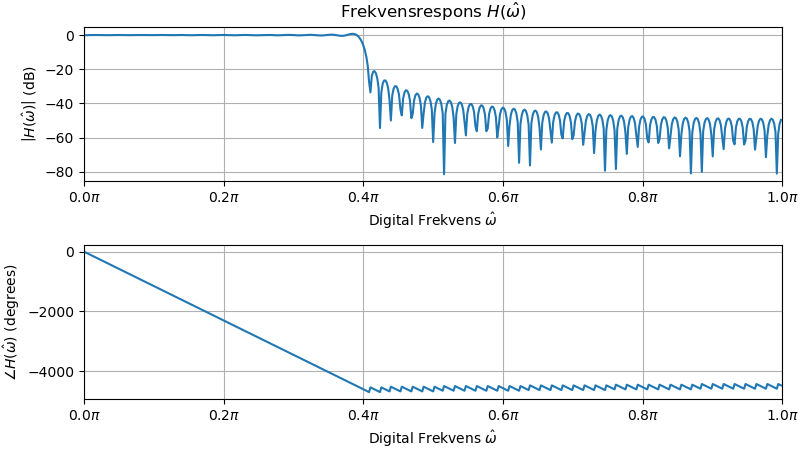

In [15]:
M = 129  # Number of filter taps
n = np.arange(M)

w_c = 0.4*pi

hn = w_c/pi*np.sinc(w_c/pi*(n-(M-1)/2))
displayFrequencyResponse(hn, num=2)

# Tilbake til frekvensplanet

* Hvordan vil approksmasjonen vår $h_{LP}[n]$ se ut i frekvensplanet?
* Impulsresponsen til det resulterende kausale FIR filteret kan skrives på følgende måte:
$$h_{LP}[n] = \delta \left[ n - \frac{M-1}{2} \right] * \left( h_I[n] \cdot w_r[n]\right)$$
    - Der $w_r[n]$ er en *rektangulær vindusfunksjon* gitt ved formelen
    $$w_r[n] = 
    \begin{cases}
1,\ \ \ \  |n| \leq \frac{M-1}{2} \\
0,\ \ \ \  |n| > \frac{M-1}{2}
\end{cases}
$$


* $DTFT$ av $h_{LP}[n]$ gir:
\begin{align}
H_{LP}(\hat{\omega}) &= \text{DTFT}(h_{LP}[n])\\
&= \text{DTFT}\left(\delta \left[ n - \frac{M-1}{2} \right] * \left( h_I[n] \cdot w_r[n]\right)\right)\\
&= e^{-j\hat{\omega}M} \cdot \left( H_I(\hat{\omega}) * W_r(\hat{\omega}) \right) 
\end{align}


$$\text{der}$$


$$W_r(\hat{\omega}) = \frac{\sin\left(\hat{\omega}(M)/2\right)}{\sin(\hat{\omega}/2)}$$

<img src="Figurer/12_DTFT%20og%20filterdesign/Slide5.PNG" style="width: 90%; margin-left: 50px" />

<img src="Figurer/12_DTFT%20og%20filterdesign/Slide6.PNG" style="width: 80%; margin-left: 50px" />

# Sentrale begrep for filterdesign


<div style="width: 100%;">
<img src="Figurer/12_DTFT%20og%20filterdesign/Fig1_FilterParams.png" style="width: 60%; float: left" />
    <div style="width: 30%; float: right; margin-left: -10%">
    <ul>
        <li><b>Stoppbåndsdemping:</b><br>minimum antall dB demping av signalkomponenter i stoppbåndet.</li>
        <li><b>Stoppbånd:</b><br>frekvensområdet der demping signalkomponenter er minst like stor som stoppbåndsdempingen. </li>
        <li><b>Passbånd rippel:</b><br>maksimal akseptabel variasjon i pass båndet.</li>
        <li><b>Passbånd:</b><br>frekvensområdet der amplitudeendring av signalkomponenter ikke overskrider passbånd rippel.</li>
        <li><b>Transisjonsbånd:</b><br> frekvensområdet mellom stoppbånd og passbånd.</li>
    </ul> 
    </div>
</div> 


# Filteregenskaper grafisk
<img src="Figurer/12_DTFT%20og%20filterdesign/Slide7.PNG" style="width: 80%; margin-left: 50px" />

# Kommentarer til filteregenskaper: 

* Filteret har lineæar faserespons med fast tidsforskyvning på $\frac{M-1}{2}$ sampler i passbåndet uansett frekvens.
* Dempingen i stoppbåndet er $\geq 21$dB, som tilsvarer en dempingsfaktor på ca. 11.
    * $21$dB stoppbåndsdemping (stopband attenuation) er fast for alle rektangulære vindu uavhengig av lengen på filteret.
* For å oppnå høyere stoppbåndsdemping er det nødvendig å finne en mer passende vindusfunksjon.
    * Vi ser på vindu med oddetalls lengde.

# Forslag: Hamming vindu

* Uttrykk: 
$$w[n] = 0.54 - 0.46 \cdot \cos\left(\frac{2\pi \cdot n}{M}\right)$$
<img src="Figurer/12_DTFT%20og%20filterdesign/Slide9.PNG" style="width: 60%; margin-left: 50px" />

# Frekvensrespons til filter med Hamming vindu
<img src="Figurer/12_DTFT%20og%20filterdesign/Slide10.PNG" style="width: 90%; margin-left: 50px" />

## Kodeeksempel 2:
* Bruk en vindusfunksjon til å øke stoppbåndsdempingen i filteret fra eksempel 1.

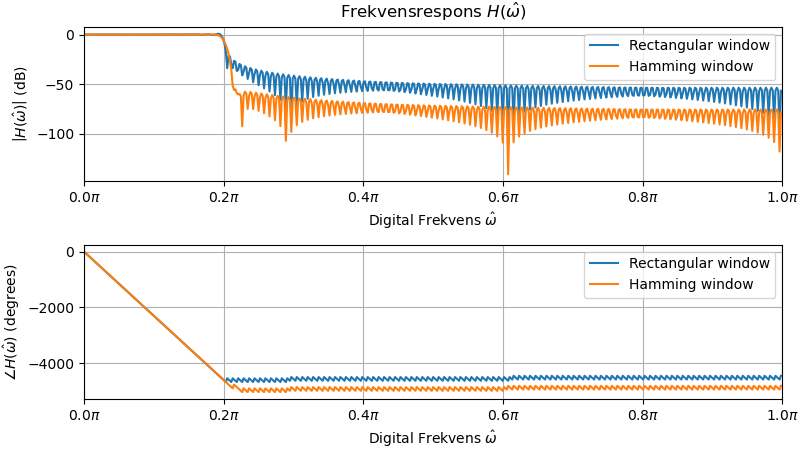

In [21]:
M = 257

n = np.arange(M)
w_c = 0.2*pi

hn_rect = w_c/pi*np.sinc(w_c/pi*(n-(M-1)/2))
hn_hamming = hn_rect * sig.windows.hamming(M)

displayFrequencyResponse(hn_rect, num=3, label="Rectangular window")
displayFrequencyResponse(hn_hamming, num=3, label="Hamming window", new_figure=False)

# Realisering av FIR lavpassfilter (vindusmetoden)
<img src="Figurer/12_DTFT%20og%20filterdesign/Slide11.PNG" style="width: 90%; margin-left: 50px" />

# Vindusmetoden i frekvensplanet
<img src="Figurer/12_DTFT%20og%20filterdesign/Slide12.PNG" style="width: 90%; margin-left: 50px" />

# Transformasjon av filtre

* FIR filtre er svært enkle å gjøre endringer på, ettersom vi kan justere hver sample i impulsresponsen individuelt.
* Ettersom filterets frekvensrespons og impulsresponsens frekvensinnhold er det samme, er det en rekke verktøy vi kan ta i bruk for å gjøre endringer på filteregenskaper.
    * Noen av de mest aktuelle er *Amplitudemodulasjon* og *Vindusfunksjoner*.
        * Disse begrepene har vi arbeidet med i `Dataøving 2`

# Lavpassfilter $\rightarrow$ Høypassfilter

* Et lavpassfilter kan konverteres til et høypassfilter ved å "mikse" impulsresponsen med en sinussekvens som forskyver passbåndet med $\frac{f_s}{2} \text{ Hz}$ / $\pi \text{ rad}$.
    \begin{align}
    h_{HP}[n] &= h_{LP}[n]\cdot \cos(\pi\cdot n)\\
    &= h_{LP}[n]\cdot \left(e^{j\pi\cdot n}+e^{-j\pi\cdot n}\right) \cdot \frac{1}{2}\\
    &=  h_{LP}[n]\cdot e^{j\pi\cdot n} +  h_{LP}[n]\cdot e^{-j\pi\cdot n}\cdot \frac{1}{2} \\ \\
    H_{HP}(\hat{\omega})&= \left(H_{LP}(\hat{\omega} - \pi) + H_{LP}(\hat{\omega} + \pi)\right) \cdot \frac{1}{2} \\
  &= \left(2\cdot H_{LP}(\hat{\omega} - \pi)\right) \cdot \frac{1}{2} \ \ \ \text{(aliasing)}\\
  &= H_{LP}(\hat{\omega} - \pi) \\
  &= H_{LP}^*(\pi - \hat{\omega})
    \end{align}

# Høypassfilter:
* Lag et høypassfilter med "passbånd" mellom $\hat{\omega}_{c} = 0.8\pi$ og $\hat{\omega} = \pi$ og filterorden 128 ved å benytte modulasjon av et lavpassfilter.

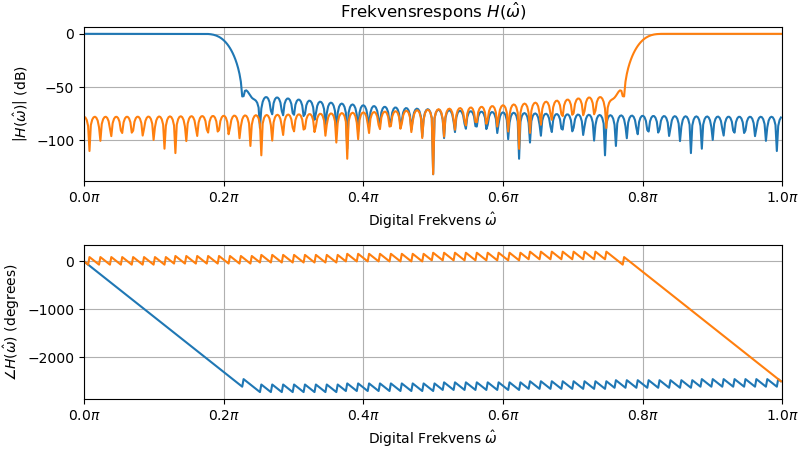

In [28]:
M = 129

w_c = 0.2*pi 

n = np.arange(M)
hn_lp = w_c/pi*np.sinc(w_c/pi*(n-(M-1)/2)) # Lavpassfilter uten vindusfunksjon
hn_lp *= sig.windows.hamming(M) # Legg til vindusfunksjon "hamming"

hn_hp = hn_lp*cos(pi*(n-(M-1)/2)) # Frekvensforskyvning av passbånd

displayFrequencyResponse(b=hn_lp, num=4)
displayFrequencyResponse(b=hn_hp, num=4, new_figure=False)

# Lavpassfilter $\rightarrow$ Båndpassfilter

* Et lavpassfilter kan konverteres til et båndpassfilter ved å "mikse" impulsresponsen med en sinussekvens.
    \begin{align}
    h_{BP}[n] &= 2\cdot h_{LP}[n]\cdot \cos(\hat{\omega}_{BP}\cdot n)\\
    &= h_{LP}[n]\cdot \left(e^{j\hat{\omega}_{BP}\cdot n}+e^{-j\hat{\omega}_{BP}\cdot n}\right)\\
    &=  h_{LP}[n]\cdot e^{j\hat{\omega}_{BP}\cdot n} +  h_{LP}[n]\cdot+e^{-j\hat{\omega}_{BP}\cdot n} \\ \\
    H_{BP}(\hat{\omega})&= H_{LP}(\hat{\omega} - \hat{\omega}_{BP}) + H_{LP}(\hat{\omega} + \hat{\omega}_{BP})
    \end{align}
    * $\hat{\omega}_{BP}$ vil da være senterfrekvensen til passbåndet.
    * Sinussekvensen vi mikser med har amplitude 2 slik at amplituden til positivt og negativt frekvensforskjøvet signalinnhold holder seg lik.

# Båndpassfilter:
* Lag et båndpassfilter med "passbånd" mellom $\hat{\omega}_{LP} = 0.3\pi$ og $\hat{\omega}_{HP} = 0.5\pi$ og filterorden 128 ved å benytte modulasjon av et lavpassfilter.

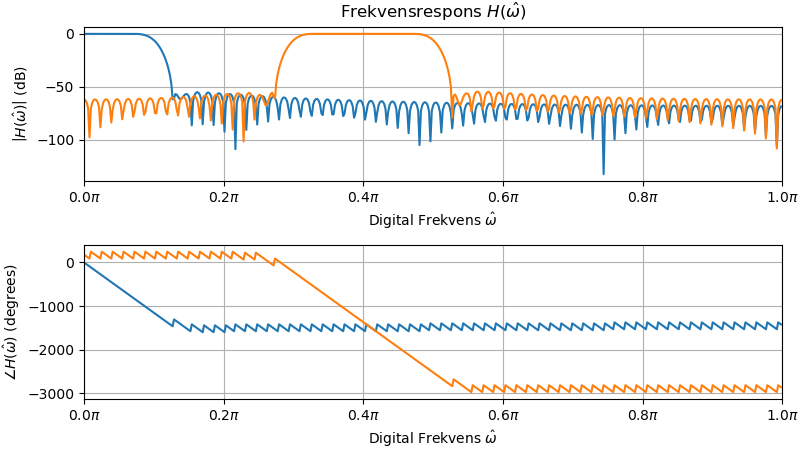

In [31]:
M = 129

w_c = 0.1*pi 

n = np.arange(M)
hn_lp = w_c/pi*np.sinc(w_c/pi*(n-(M-1)/2)) # Lavpassfilter uten vindusfunksjon
hn_lp *= sig.windows.hamming(M) # Legg til vindusfunksjon "hamming"

hn_bp = hn_lp*2*cos(0.4*pi*(n-(M-1)/2)) # Frekvensforskyvning av passbånd

displayFrequencyResponse(b=hn_lp, num=4)
displayFrequencyResponse(b=hn_bp, num=4, new_figure=False)

# Båndstoppfilter:
* Lag et båndpassfilter med "stoppbånd" mellom $\hat{\omega}_{LP} = 0.3\pi$ og $\hat{\omega}_{HP} = 0.5\pi$ og filterorden 128 ved å kompbinere høypassfilter og lavpassfilter

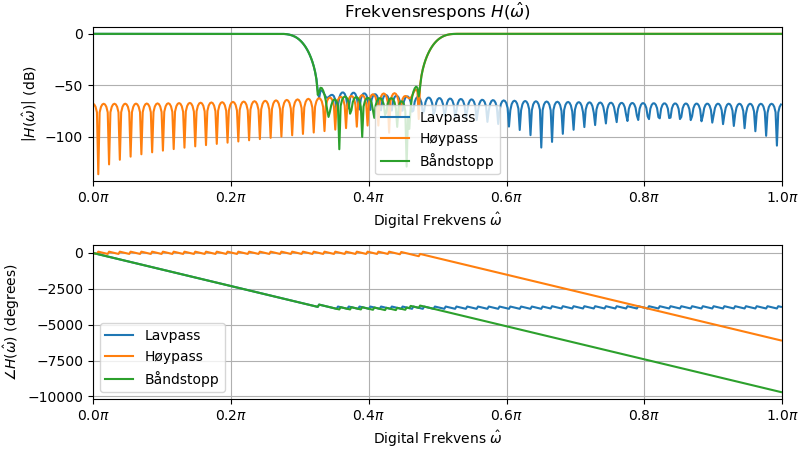

In [72]:
M = 128


n = np.arange(M+1)
hn_lp = 0.3*np.sinc(0.3*(n-M/2)) # Lavpassfilter uten vindusfunksjon
hn_lp *= sig.windows.hamming(M+1) # Legg til vindusfunksjon "hamming"


hn_hp = 0.5*np.sinc(0.5*(n-M/2)) # Lavpassfilter uten vindusfunksjon
hn_hp *= sig.windows.hamming(M+1) # Legg til vindusfunksjon "hamming"
hn_hp *= cos(pi*(n-M/2))

hn_bs = hn_lp + hn_hp

displayFrequencyResponse(b=hn_lp, label="Lavpass", num=4)
displayFrequencyResponse(b=hn_hp, label="Høypass",num=4, new_figure=False)
displayFrequencyResponse(b=hn_bs, label="Båndstopp", num=4, new_figure=False)

# Komplementærfilter

* Et filter med magnitude response $|H(\hat{\omega})|$ sitt komplementærfilter vil ha en magntude response som komplementerer det originale filteret:
$$|H_{\text{comp}}(\hat{\omega})| = 1 - |H(\hat{\omega})|$$
* Hvordan finne et komplementærfilter:
    * Lage et "allpassfilter" som har samme faserespons i passbåndet som det originale filteret
    * Subtrahere impulresponsen til filteret $h[n]$ fra allpassfilteret

* For FIR filter $h[n]$ med *oddetalls* lengde $M$
$$h_{\text{comp}}[n] = \delta\left[n-\frac{M-1}{2}\right] - h[n]$$

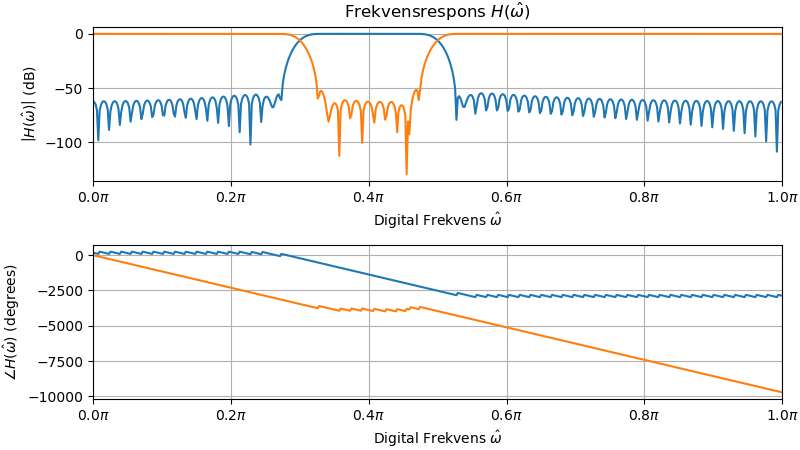

In [75]:

#displayFrequencyResponse(hn_bs, num=5)
M = len(hn_bs)

# Delayed delta pulse
dn = np.zeros(M)
dn[int((M-1)/2)] = 1

hn = dn - hn_bs

displayFrequencyResponse(hn, num=5, new_figure=True)
displayFrequencyResponse(hn_bs, num=5, new_figure=False)
#plt.figure()
#plt.stem(hn)
#plt.stem(hn_lp)

# Arbitrært filter med IFFT (frekvenssampling)

* Vi kan også designe filter ved å definere en diskrét ønsket frekvensresopons $H[m]$
* Viktig å tidsforskyve med $D = \frac{M-1}{2}$ før invers fouriertransformasjon
* Mindre presis metode, da vi ikke har kontroll på hva som skjer mellom samplene i $H[m]$
    * Mulig å tilpasse med vindusfunksjoner

/tmp/ipykernel_337/3968583617.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, [ax1, ax2] = plt.subplots(num=num, nrows=2)


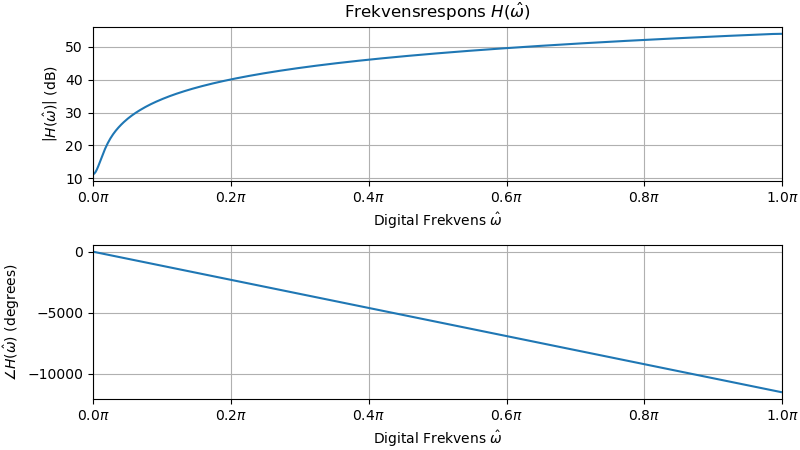

In [63]:
M = 129
m = np.arange(M//2+1)

fs = 1000
f_c = 200

#Hm = np.where(m/M*fs > f_c, 0, 1) + 0j
Hm = np.linspace(0, 500, M//2+1) + 0j
Hm *= np.exp(-2j*pi*m/M*(M-1)/2)

hn = np.fft.irfft(Hm, n=M)*sig.windows.hamming(M)

displayFrequencyResponse(hn)



# 'Optimale' FIR-filtre

* FIR-filtre designet med Parks-McClellan algoritmen beskrevet i kapittel 5.6 i boka, kan genereres med funsjonen [`scipy.signal.remez()`](https://docs.scipy.org/doc/scipy-1.8.0/html-scipyorg/reference/generated/scipy.signal.remez.html).
* Vi bruker en rekke arrayer til å spesifisere *nøyaktig* hvordan vi ønsker at filteret skal være.
* Filteret returnerer det optimale filteret med gitt filterorden som er mest mulig likt kravene:
    * Alle de små "toppene" i stoppbåndet vil være nøyaktig like høye.
    * Passbånd rippel er like stor over hele passbåndet
    * Gir et filter med litt lavere filterorden enn et filter designet med vindusmetoden gitt samme krav til ytelse.


# Lavpassfilter

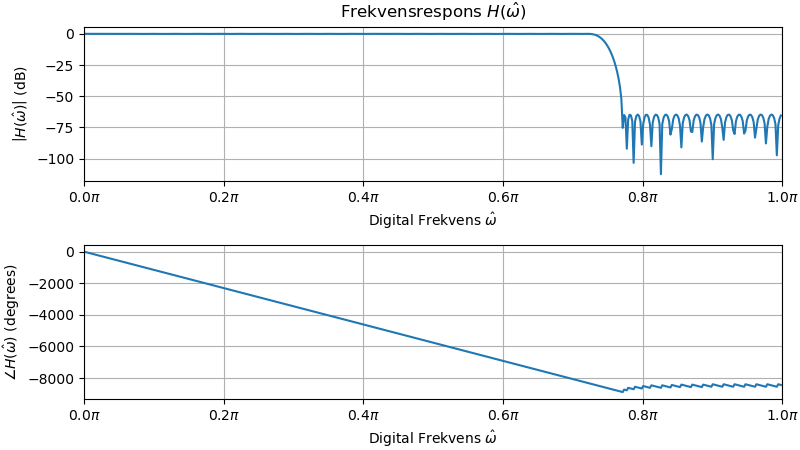

In [78]:
fs = 22050.0       # Sample rate, Hz
cutoff = 8000.0    # Desired cutoff frequency, Hz
trans_width = 500  # Width of transition from pass band to stop band, Hz
numtaps = 129      # Size of the FIR filter.

hn = sig.remez(numtaps,                                    # Lengde på impulsrespons = filterorden + 1
               [0, cutoff, cutoff + trans_width, 0.5*fs],  # Alle 'kantfrekvensene' etter tur 
               [1, 0],                                     # Ønsket filtergain i de ulike båndene
               fs=fs,                                      # Samplingsfrekvens
               weight=[1, 10],                             # Vi "bryr oss" 10 ganger mer om demping i 
                                                           # stoppbånd enn rippel/variasjoner i passbånd
              )

displayFrequencyResponse(b=hn)

# Båndbegrenset derivasjonsfilter

/tmp/ipykernel_337/3625525585.py:6: DeprecationWarning: 'remez' keyword argument 'Hz' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  hn = sig.remez(numtaps,                                    # Lengde på impulsrespons = filterorden + 1


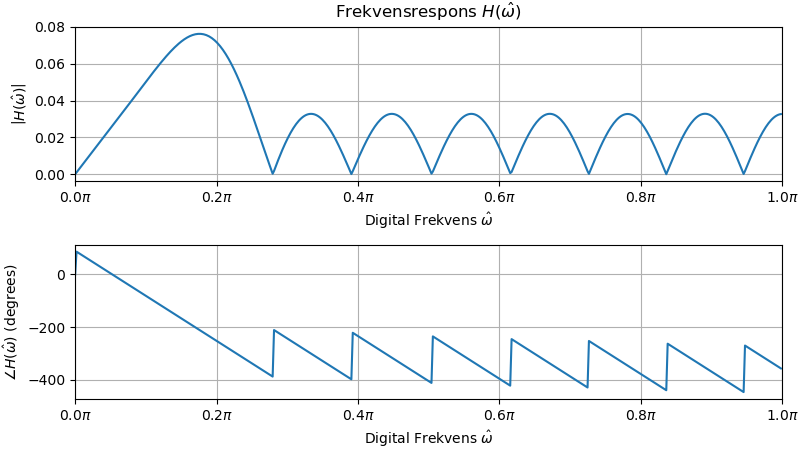

In [76]:
fs = 8000         # Sample rate, Hz
cutoff = 500     # Desired cutoff frequency, Hz
trans_width = 500 # Width of transition from pass band to stop band, Hz
numtaps = 20      # Size of the FIR filter.

hn = sig.remez(numtaps,                                    # Lengde på impulsrespons = filterorden + 1
               [0, cutoff, cutoff + trans_width, 0.5*fs],  # Alle 'kantfrekvensene' etter tur 
               [1, 0],                                     # Ønsket filtergain i de ulike båndene
               Hz=fs,                                      # Samplingsfrekvens
               weight=[10, 1],                             # Vi "bryr oss" 10 ganger mer om rippel i passbånd 
                                                           # enn demping i stoppbånd
               type='differentiator'
              )

displayFrequencyResponse(b=hn, mag='lin')

# Oppsummering frekvensrespons og filterdesign

* Design av FIR filtre går ut på å definere ønskede egenskaper i frekvensdomenet, og regne seg fram til en impulsrespons som kommer så nære de egenskapene som mulig.
    * Gir veldig stor fleksibilitet til å finne *nøyaktig* det filteret vi ønsker, men kan ofte involvere *svært* høy filterorden.
* Den *lineære faseresponsen* er ofte hovedmotivasjonen for å bruke FIR filtre.
    * Dersom de forskjellige frekvenskomponentene i et signal forskyves ulikt, vil også signalets *bølgeform* påvirkes. Dette er f.eks. ikke gunstig for lydsignal, og FIR filtre dominerer i behandling av lydsignal av den grunn.

# Andre spørsmål?